## Edmunds Discssion Forum Analysis - Automobile Industry - NLP

### Objective: 
To Analyze Edmund cars discussion forum to understand the brand similarites, their association with other brnads and important attributes. The following questions were answered in this analysis:
    1. Which brands are significantly associated (mentioned together) with each other?
    2. Which attributes each brand is associated with
    3. Which are the most aspirational brands in terms of people actually wanting to buy or own? 

### Scraper

The URL that I scraped data from is 'https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0'. I fetched data from 539 pages which included posts from 2007 to 2019. I chose to pick 10000 posts from 2007 onwards.

The scraper code was implemented on Google Colab.

#### Note: Run the below code on Google Colab

In [1]:
#!kill -9 -1 # Use this line to delete this VM and start a new one. 
# The above line deletes all files and folders from the current VM and allocates a new one.

!pip install selenium
!apt-get -q update # to update ubuntu to correctly run apt install
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

^C


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
import pandas as pd
driver = webdriver.Chrome('chromedriver', options=chrome_options)
df_edmund = pd.DataFrame(columns = ['Date','user_id','comments']) 

In [ ]:
for j in range(1,539):
  url_1='https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p'+str(j)
  driver.get(url_1)
  #Each page has 50 comments . Total number of pages: 539
  for i in range(1,50):
    # Extract user ID
    xpath_user='/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li['+ str(i) +']/div/div[2]/div[1]/span[1]/a[2]'
    userid_element = driver.find_elements_by_xpath(xpath_user)[0]
    userid = userid_element.text
    # Extract Date
    xpath_date='/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[' + str(i) + ']/div/div[2]/div[2]/span/a/time'
    date_element = driver.find_elements_by_xpath(xpath_date)[0]
    date_ele = date_element.text
    # Extract comment
    xpath_comment='/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li['+ str(i)+']/div/div[3]/div/div[1]'
    comment_element = driver.find_elements_by_xpath(xpath_comment)[0]
    comment = comment_element.text
    
    # Append to the dataframe
    df_edmund.loc[len(df_edmund)] = [date_ele,userid,comment]

print(df_edmund)

In [ ]:
#export to txt :
df_edmund.to_csv("scraped_edmund.txt", sep="^")

### Data Pre-Processing

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

In [3]:
## Read in the scraped data
posts = pd.read_csv("scraped_edmund.csv", encoding = 'unicode_escape')
posts = posts.drop(columns= ["Unnamed: 0"])

## Read in the model-brand mapping data
model_brand = pd.read_csv("models.csv", header = None)
model_brand.columns = ['brand','model']

In [5]:
## Filter out the first 10000 comments
posts = posts.head(10000)

In [6]:
## Create dictionary for model to brand mapping
model_brand = model_brand.set_index('model')
model_brand_dict = model_brand["brand"].to_dict()

In [135]:
## Create the dictionary with brands as keys and models as the values for mapping
#model_brand_dict = model_brand.stack().groupby(level=0).apply(list).to_dict()

In [7]:
## Removing stop words, punctuation and tokenizing
stop = stopwords.words('english')

posts["comments"] = posts["comments"].astype(str)
posts["comments_tokens"] = posts["comments"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
posts["comments_tokens"] = posts["comments_tokens"].apply(lambda list_of_words: [x if x not in model_brand_dict else model_brand_dict[x] for x in list_of_words])
posts["comments_tokens"] = posts["comments_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])

In [8]:
## Get all the unique tokens in each comments
posts["comments_unique"] = posts["comments_tokens"].apply(lambda x: sorted(set(x)))

### Brand Association based on lifts and MDS plots

In [9]:
## Get frequency of all words
all_words = posts['comments_unique'].sum()
freq_dist = nltk.FreqDist(all_words)

In [10]:
## Get the frequency counts of all brands
all_brands_dict = {your_key: freq_dist[your_key] for your_key in freq_dist.keys() if your_key in model_brand_dict.values()}
all_brands = pd.DataFrame.from_dict(all_brands_dict, orient='index').reset_index()
all_brands.columns = ["brand","word_frequency"]
all_brands.sort_values("word_frequency", ascending= False, inplace=True)

In [11]:
all_brands = all_brands[~all_brands.brand.isin(['car','problem','sedan','seat'])]

#### Frequency Table of Top-10 brands

In [12]:
## Display the top 10 brands by frequency count, but eliminating non-brands
top_brands = all_brands.head(10)
top_brands

,brand,word_frequency
1,honda,3978
7,ford,2265
3,toyota,2137
21,hyundai,1398
14,mazda,1254
9,nissan,1083
0,chevrolet,792
17,chrysler,582
10,saturn,525
16,subaru,301


In [49]:
posts.head()

,Date,user_id,comments,comments_tokens,comments_unique
0,Sep-07,1487,the media says it quite often. I just read an ...,"[media, says, quite, often, read, article, new...","[article, cant, checked, chevrolet, crown, dom..."
1,Sep-07,andres3,when you factor in the superior warranty you g...,"[factor, superior, warranty, get, brands, thin...","[best, brands, chances, customer, dice, even, ..."
2,Sep-07,1487,"""Also, Camry's ride very nicely on the straita...","[also, toyota, ride, nicely, straitaways, comf...","[also, american, anyone, benchmark, bread, bui..."
3,Sep-07,1487,"""You might be willing to roll the dice and tak...","[might, willing, roll, dice, take, chances, pe...","[2, 30, 5, 50, 90, acting, amongst, annual, an..."
4,Sep-07,andres3,"Toyota's ride nice and soft, whereas Buicks I'...","[toyota, ride, nice, soft, whereas, buick, rid...","[2008, 40, advantage, also, barge, boat, buick..."


#### Function to calculate the Lift

In [13]:
## Function to calculate lift
def calculate_lift(a, b, tokenized_posts):
    num_a = 0
    num_b = 0
    num_a_b = 0
    n = len(tokenized_posts)
    if a==b:
        return 1
    for i in tokenized_posts:
        if a in i:
            num_a += 1
        if b in i:
            num_b += 1
        if a in i and b in i:
            num_a_b += 1
    if num_a == 0:
        return (float(n)*num_a_b)/(num_b)
    elif num_b == 0:
        return (float(n)*num_a_b)/(num_a)
    else:
        return (float(n)*num_a_b)/(num_a*num_b)   

In [14]:
## Get the lift scores for the top-10 brands
num_brands = 10

## print(top_brands)
top_brands = top_brands.head(num_brands)
lift_brands = []
for index, brand_a in top_brands.iterrows():
    for index, brand_b in top_brands.iterrows():
        lift_brands.append(calculate_lift(brand_a.brand, brand_b.brand, posts.comments_unique))

In [15]:
lift_brands_df = np.reshape(lift_brands,(num_brands,num_brands))

#### Lift Matrix

In [16]:
lift_brands = pd.DataFrame(data= lift_brands_df)

for i in range(10):
    lift_brands = lift_brands.rename(columns = {i: top_brands.iloc[i, 0]})
    lift_brands = lift_brands.rename(index = {i: top_brands.iloc[i, 0]})
lift_brands

,honda,ford,toyota,hyundai,mazda,nissan,chevrolet,chrysler,saturn,subaru
honda,1.000000,1.211964,1.751562,1.438527,1.142648,1.592322,1.523531,1.451281,1.541813,1.536691
ford,1.211964,1.000000,1.518499,1.301133,1.443504,1.451287,1.466096,1.380639,1.522128,1.173425
toyota,1.751562,1.518499,1.000000,1.827599,1.160535,2.376456,2.168385,1.503537,2.076788,1.290349
hyundai,1.438527,1.301133,1.827599,1.000000,1.249221,1.968252,1.869554,1.732962,1.621364,1.711035
mazda,1.142648,1.443504,1.160535,1.249221,1.000000,1.678838,1.057223,0.863217,1.199970,2.834783
nissan,1.592322,1.451287,2.376456,1.968252,1.678838,1.000000,2.238451,1.427878,2.866816,2.270057
chevrolet,1.523531,1.466096,2.168385,1.869554,1.057223,2.238451,1.000000,1.865736,4.978355,1.761804
chrysler,1.451281,1.380639,1.503537,1.732962,0.863217,1.427878,1.865736,1.000000,1.570938,1.427087
saturn,1.541813,1.522128,2.076788,1.621364,1.199970,2.866816,4.978355,1.570938,1.000000,1.898434
subaru,1.536691,1.173425,1.290349,1.711035,2.834783,2.270057,1.761804,1.427087,1.898434,1.000000


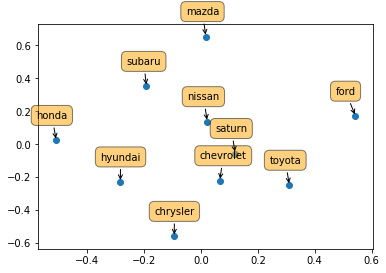

In [48]:

# Calculating the dissimilarity matrix which is the input for plotting MDS plot
dissimilarity_matrix = 1/lift_brands
np.fill_diagonal(dissimilarity_matrix.values, 0)

# Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(lift_brands, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points',ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

### Insights to the brand managers of  car companies

When looking at Mazda's placement on the MDS plot, we can see that it stands in somewhat isolation. As the brand manager, it makes more sense to focus on creating a stronger brand for Mazda, so that when people are talking about Subaru or Nissan, Mazda comes into their mind too. However, the strategy to attract customers from these brands will differ. For Subaru, Mazda should attract those who have are looking to upgrade themselves to a more powerful engine while maintaining day-to-day comfort. It can pit against Subaru directly, which is currently seen as a family car and hence focusses more on space rather than performance. On the other hand, Mazda is probably comparable to what a high-end Nissan could offer its customers. Mazda has a better brand premium, and we can use this as leverage to pull in Nissan users who are looking for a change. This may also be a good strategy when dealing with Saturn, as the association between Mazda and Saturn is slightly higher than with Nissan. Another advantage that Mazda has over Saturn customers is that with Saturn no longer manufacturing cars, customers are looking for a new brand to align with. Mazda should exploit this opportunity and have directed ads towards this user base.

Chevrolet is an American brand and has been associated with the country's image. When you think of American cars, Chevrolet comes to mind and it should use this image to its advantage. Its mid-sized sedans are closest in their look and feel to that of its Japanese equivalent models, like Nissan, Toyota or Hyundai. Hence it would be most suitable to attract the customers of these three competitors to switch. They also have similar price-tags, thus by better advertising their features and focusing on its legacy, it can maximize on people's loyalty to home brands. The next target for Chevrolet should be Ford. Ford is still seen a more family car brand and Chevrolet should sell itself as a more upscale sedan.

### Which attributes are most strongly associated with which of these 5 brands? 

#### Steps followed to obtain the list of attributes:

1. Found the list of nouns & adjectives which define the attributes 
2. Manually went through a few comments and the list to decide on the final list of attributes (245 attributes(
3. Obainted the lift values and frequency for these attributes
4. Based on the lift values and frequencies, grouped the attributes to final 22 groups
5. Found top 5 attributes based on the frequency
6. Calculated the lift values for these attributes with the top brands

In [18]:
# Import required functions from the libraries
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer # to remove punctuations
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sahana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
#Obtain POS for the tokens
import nltk
nltk.download('averaged_perceptron_tagger')
posts['pos']=posts['comments_unique'].apply(nltk.tag.pos_tag)
posts[:5]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sahana\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


,Date,user_id,comments,comments_tokens,comments_unique,pos
0,Sep-07,1487,the media says it quite often. I just read an ...,"[media, says, quite, often, read, article, new...","[article, cant, checked, chevrolet, crown, dom...","[(article, NN), (cant, NN), (checked, VBD), (c..."
1,Sep-07,andres3,when you factor in the superior warranty you g...,"[factor, superior, warranty, get, brands, thin...","[best, brands, chances, customer, dice, even, ...","[(best, JJS), (brands, NNS), (chances, NNS), (..."
2,Sep-07,1487,"""Also, Camry's ride very nicely on the straita...","[also, toyota, ride, nicely, straitaways, comf...","[also, american, anyone, benchmark, bread, bui...","[(also, RB), (american, JJ), (anyone, NN), (be..."
3,Sep-07,1487,"""You might be willing to roll the dice and tak...","[might, willing, roll, dice, take, chances, pe...","[2, 30, 5, 50, 90, acting, amongst, annual, an...","[(2, CD), (30, CD), (5, CD), (50, CD), (90, CD..."
4,Sep-07,andres3,"Toyota's ride nice and soft, whereas Buicks I'...","[toyota, ride, nice, soft, whereas, buick, rid...","[2008, 40, advantage, also, barge, boat, buick...","[(2008, CD), (40, CD), (advantage, NN), (also,..."


In [20]:
# Extract the list of nouns :
posts['nouns']=posts['pos'].apply(lambda pos_list: [x[0] for x in pos_list if x[1].startswith('NN')])
posts[:5]

,Date,user_id,comments,comments_tokens,comments_unique,pos,nouns
0,Sep-07,1487,the media says it quite often. I just read an ...,"[media, says, quite, often, read, article, new...","[article, cant, checked, chevrolet, crown, dom...","[(article, NN), (cant, NN), (checked, VBD), (c...","[article, cant, dominate, dont, honda, loses, ..."
1,Sep-07,andres3,when you factor in the superior warranty you g...,"[factor, superior, warranty, get, brands, thin...","[best, brands, chances, customer, dice, even, ...","[(best, JJS), (brands, NNS), (chances, NNS), (...","[brands, chances, customer, dice, people, serv..."
2,Sep-07,1487,"""Also, Camry's ride very nicely on the straita...","[also, toyota, ride, nicely, straitaways, comf...","[also, american, anyone, benchmark, bread, bui...","[(also, RB), (american, JJ), (anyone, NN), (be...","[anyone, benchmark, bread, buick, building, bu..."
3,Sep-07,1487,"""You might be willing to roll the dice and tak...","[might, willing, roll, dice, take, chances, pe...","[2, 30, 5, 50, 90, acting, amongst, annual, an...","[(2, CD), (30, CD), (5, CD), (50, CD), (90, CD...","[anything, auto, axles, brands, buyers, car, c..."
4,Sep-07,andres3,"Toyota's ride nice and soft, whereas Buicks I'...","[toyota, ride, nice, soft, whereas, buick, rid...","[2008, 40, advantage, also, barge, boat, buick...","[(2008, CD), (40, CD), (advantage, NN), (also,...","[advantage, boat, buick, engineering, example,..."


In [21]:
#Filter the noun list only to make the list of attributes 
noun_lst = posts['nouns'].apply(pd.Series).stack().unique()

# get the frequencies for the nouns:
noun_df= pd.DataFrame(noun_lst)
noun_df.columns=['nouns']

# join with frequency table

## get frequency of all words
all_words = posts['comments_unique'].sum()
freq_dist = nltk.FreqDist(all_words)

df_fdist=pd.DataFrame(list(freq_dist.items()), columns=['term', 'freq'])

noun_freq_df = pd.merge(noun_df, df_fdist, right_on='term', left_on='nouns')
noun_freq_df[:5]

,nouns,term,freq
0,article,article,153
1,cant,cant,38
2,dominate,dominate,27
3,dont,dont,142
4,honda,honda,3978


In [22]:
## Upload the final list of attributes along with their grouped names (synonym)

attr_df= pd.read_csv('attributes_vff.csv') 
attr_df[:5]

,attribute,synonym
0,price,price
1,power,power
2,interior,design
3,speed,speed
4,cost,price


In [23]:
## Create dictionary for attribute to synonym mapping
attr_df = attr_df.set_index('attribute')
attr_dict = attr_df["synonym"].to_dict()
posts["attr_tokens"] = posts["comments_unique"].apply(lambda list_of_words: [attr_dict[x] for x in list_of_words if x in attr_dict  ])

In [24]:
# Define top 5 brands by frequency obtained previously
import numpy as np
top_brands=['honda','ford','toyota','hyundai','mazda']

# Get unique list of grouped attribute names
uniq_attr=np.unique(attr_df['synonym'])
uniq_attr

array(['capability', 'country', 'credibility', 'design', 'efficiency',
       'luxury', 'maintenance', 'performance', 'power', 'price',
       'quality', 'rating', 'reliability', 'safety', 'size', 'speed',
       'sporty', 'technology', 'type', 'warranty'], dtype=object)

In [25]:
# Find top 5 attributes:

def calc_freq(tokenized_posts,find_list):
    freq_a=0
    for i in tokenized_posts:
        if find_list in i:
            freq_a += 1
    return freq_a
  
# Calculate freq for attr
df_top_attr=pd.DataFrame(columns=['attribute','freq'])
for i,attr in enumerate(uniq_attr):
        temp_freq=calc_freq( posts.comments_unique,str(attr))
        df_top_attr.loc[i]=[str(attr),temp_freq]

In [26]:
#Sort the top attributes
top_attr=df_top_attr.sort_values(by='freq',ascending=False).head(5)
top_attr['attribute']

9       price
8       power
15      speed
14       size
10    quality
Name: attribute, dtype: object

In [27]:
# Grouped Brands and attribute lifts 
df_lift_brand_attr=pd.DataFrame(columns=['brand','attribute','lift'])
i=0
for  brand_a in top_brands:
    for attr in top_attr['attribute']:
        temp_lift=calculate_lift(str(brand_a), str(attr), posts.comments_unique)
        df_lift_brand_attr.loc[i]=[ str(brand_a),str(attr),temp_lift]
        i=i+1

In [28]:
df1 = df_lift_brand_attr.sort_values('lift',ascending = False).groupby('brand').head(10)
print(df1.sort_values(['brand','lift'],ascending=[True,False]))

      brand attribute      lift
8      ford      size  1.577356
9      ford   quality  1.504308
6      ford     power  1.314441
5      ford     price  1.194585
7      ford     speed  1.140870
4     honda   quality  1.540732
0     honda     price  1.429308
3     honda      size  1.399077
1     honda     power  1.260494
2     honda     speed  1.219094
15  hyundai     price  1.926514
18  hyundai      size  1.322741
19  hyundai   quality  1.312359
16  hyundai     power  1.202369
17  hyundai     speed  0.924203
21    mazda     power  1.692589
20    mazda     price  1.551146
22    mazda     speed  1.481983
23    mazda      size  1.403051
24    mazda   quality  1.045043
14   toyota   quality  2.141606
13   toyota      size  1.646631
10   toyota     price  1.604552
11   toyota     power  1.286517
12   toyota     speed  0.861351


#### Lift Matrix of the brands and the top-5 attributes

In [29]:
lift_matrix = df1.pivot(index='brand', columns='attribute')
lift_matrix

lift                                        
attribute     power     price   quality      size     speed
brand                                                      
ford       1.314441  1.194585  1.504308  1.577356  1.140870
honda      1.260494  1.429308  1.540732  1.399077  1.219094
hyundai    1.202369  1.926514  1.312359  1.322741  0.924203
mazda      1.692589  1.551146  1.045043  1.403051  1.481983
toyota     1.286517  1.604552  2.141606  1.646631  0.861351

#### Appedix Code:
Before deciding to combine the attributes into final 22 groups, I examined the lift values of all the attributes with the brands to confirm if the binning was appropriate. 

In [ ]:
## Appedix Code:
## Before deciding to combine the attributes into final 22 groups 

#uniq_attr_org=np.unique(attr_df['attribute'])

# Brand and attribute lifts 
#df_lift_brand_attr_org=pd.DataFrame(columns=['brand','attribute','lift'])
#i=0
#for  brand_a in top_brands:
#    for attr in uniq_attr_org:
#        temp_lift=calculate_lift(str(brand_a), str(attr), posts.comments_unique)
#        df_lift_brand_attr_org.loc[i]=[ str(brand_a),str(attr),temp_lift]
#        i=i+1

#df_lift_brand_attr_org[:20]

### Insights to the car company managers

The data is of the year 2007 and hence in the following discussion we look at brand slogan's in the year 2007 to have a more accurate analysis.

#### Ford : 
Ford had a tagline of "Go further". It is believed to have a dual meaning of being better than competitors and improved fuel economy. Ford has a high life with size but the lift with speed and power is relatively low.
###### Product manager : 
Given the company's emphasis on being better than their competitors, the product managers should certianly need to improve the car interms of  power and speed. With a lift close to 1 ,the product managers becessarily have to work on increasing the speed of the vehicle.
###### Marketing Manager : 
Ford is considered as a affordable car by the company, but the public does not perceive this, evident by low lift values(among other attributes and even amoung other competitors!) and hence the marketing manager has to advertise  the cars as affordable and low price for its features. This may need both the product manager to improve the product and marketing managers to market the product to convey a good deal for the price and compete in the market

#### Honda : 
It had the lagline "The power of dreams" which encourages people to have the conviction to imagine and make dreams a reality which speaks to Honda's innovative nature.
###### Product manager : 
Power and speed have low lift values compared to other attributes. The product managers can focus on improving this, so that people can relate the car to its tagline of "power of dreams".Honda considers it's cars as roomy and hence the product design may need to be changed accordingly and marketed in that fashion too.
###### Marketing manager : 
Honda again considers itself as a affordable brand,its lift value woth price is 1.44, but it is low wrt to other competitors. The marketing team should better advertise honda as having reasonable prices. They can also focus on improving the image of honda interms of quality to compete with toyota.

#### Hyundai : 
"Drive your Way" was designed to communicate the company’s ‘refined and confident’ brand attributes.
###### Product Managers :
Hyundai prides in high quality products but the lift value is very low, something which is alaraming to know that people don’t associate Hyundai much with high quality. The product managers necessarily have to look into quality issues and improve it, if they pride in high quality and pass that important distinction it has from other competitiors to its customers. Power and speed also need to improved, as one needs to be decenlty good in other attributes of the car to compete in the market
###### Marketing managers: 
Hyundai is aagin an affordable brand and it has high lift among its competitors.The marketing managers can focus on improving their brand image with regard to low price to maintain their top position.

#### Mazda : 
Their ad campaign was "Zoom Zoom" to describe driving as a pleasure.
###### Product managers :
For a care to be fun to drive,  quality becomes an important factor.Also the balance between power, speed and quality is crucial. The lift value of quality is close to 1. There needs to be immediate thought on how to improve the quality to compete with others in the market.
###### Marketing Managers: 
They need to work on advertising on quality and work in unison with the product managers.

#### Toyota: 
For toyota it was "Moving forward"  means a passion for innovation and discovery.
###### Product Manager: 
People seem to asssociate toyota with very high quality which is a good news. It has the highest lift value among all its competitors. To help resonate among customers for innovation, the product managers have to work on improving the cars in terms of power and speed.
###### Marketing Managers : 
Toyota has a decent lift value with respect to others interms of price, but the managers can further try to improve the image of the brand as very affordable to its high quality. 


### Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? 

##### Approach: 
To detect if a brand is aspirational, I made a list of aspirational phrases and replaced these with the word "aspiration" in each of the posts. I then proceeded to calculate the lift of all the brands with the word "aspiration". The brand with the highest lift was deemed the most aspirational brand according to the people.
The lift between the aspirational words and the brand is an indication of the people associating the "aspirational" sentiments with the brands.

In [31]:
## Read in the file with the aspirational words
aspiration = pd.read_csv("aspiration.csv")

In [32]:
aspiration.head()

,word
0,hope
1,hope to
2,prefer
3,really want
4,dream of


In [33]:
## Function to replace the aspirational phrases with the word - "aspiration"
def asp_word_replace(comment):
    for i in aspiration['word'].index.values:
        comment = comment.lower().replace(aspiration['word'][i],'aspiration')
    return comment

In [34]:
posts["comments_replace"] = posts["comments"].apply(asp_word_replace)

In [35]:
## Tokenize the comments and remove stop words after replacing the phrases by aspiration
posts["comments_replace_tokens"] = posts["comments_replace"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
posts["comments_replace_tokens"] = posts["comments_replace_tokens"].apply(lambda list_of_words: [x if x not in model_brand_dict else model_brand_dict[x] for x in list_of_words])
posts["comments_replace_tokens"] = posts["comments_replace_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])
posts["comments_replace_tokens"] = posts["comments_replace_tokens"].apply(lambda x: sorted(set(x)))

In [36]:
## Get the lift score for all brands and aspirational words
lift_asp_brands = pd.DataFrame(columns=['Brand','Lift'])
for index, brand_a in all_brands.iterrows():
        lift_asp_brands = lift_asp_brands.append({'Brand': brand_a.brand, "Lift":calculate_lift(brand_a.brand, 'aspiration', posts.comments_replace_tokens)},
                                        ignore_index=True)

In [37]:
lift_asp_brands.sort_values(by='Lift',ascending=False).head(10)

,Brand,Lift
28,mercedes,2.202886
23,volvo,2.080503
18,buick,1.913032
24,mercedes-benz,1.789845
27,suzuki,1.752296
13,volkswagen,1.577066
26,infiniti,1.542020
10,bmw,1.523367
21,lincoln,1.492277
9,subaru,1.485667


The Lift values indicate that Mercedes is the most aspirational brand, closely followed by Volvo. This would mean that a large number of the exposure audience wishes to own a Mercedes, but for some economic reasons, they cannot. 
An important point to note is that for an aspirational brand like Mercedes, there is a fair probability that a large part of the audience who currently cannot afford it, might be able to afford it in the future. 
Being a luxury-brand, Mercedes can do well if they produce bottom-feeder lux models that can draw the mainstream audience to affordable luxury nameplates. Furthermore, Mercedes can also capitalize on leasing. Majority of the luxury cars are leased which is more affordable for the mainstream audience. 